In [1]:
import torch
import torch.utils.data as data
import zuko
import matplotlib.pyplot as plt
from zuko.flows import Flow, UnconditionalDistribution, UnconditionalTransform
from zuko.flows.autoregressive import MaskedAutoregressiveTransform
from zuko.distributions import DiagNormal
from zuko.transforms import RotationTransform
import numpy as np

# Probability in PyTorch

## Distributions

From zuko tutorials on PyTorch distributions: https://zuko.readthedocs.io/stable/tutorials/basics.html

Distributions are mathematical objects defined in pytorch: we can sample from them or we can get the log probability of points.

In [119]:
distribution = torch.distributions.Normal(torch.tensor(0.0), torch.tensor(1.0))

x = distribution.sample()  # x ~ p(X)
log_p = distribution.log_prob(x)  # log p(X = x)

x, log_p

(tensor(-1.0781), tensor(-1.5001))

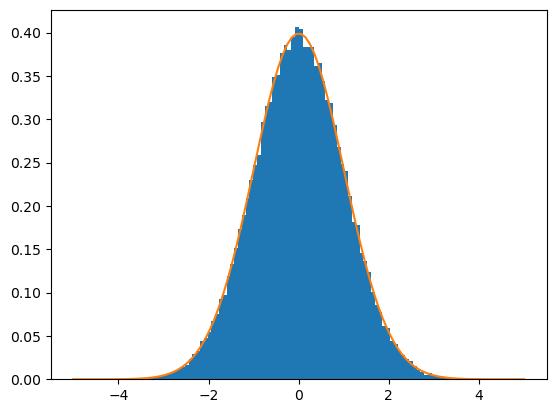

In [3]:
x = distribution.sample((100000,))

xi = torch.linspace(-5, 5, 100)
logp = distribution.log_prob(xi)

plt.hist(x, bins=100, density=True);
plt.plot(xi, logp.exp())

## Transformations

Transformations are invertible functions applied to probability distribution. 
The determinant of the jacobian needs to be available to be able to transforms p.d.f

In [4]:
transform = torch.distributions.AffineTransform(torch.tensor(2.0), torch.tensor(4.0))
distribution = torch.distributions.Uniform(low=torch.tensor(0.), high=torch.tensor(1.))

x = distribution.sample()  # x ~ p(X)
y = transform(x)  # f(x)
xx = transform.inv(y)  # f^{-1}(f(x))
ladj = transform.log_abs_det_jacobian(x, y)  # log |det df(x)/dx|

x, y, xx, ladj

(tensor(0.0580), tensor(2.2318), tensor(0.0580), tensor(1.3863))

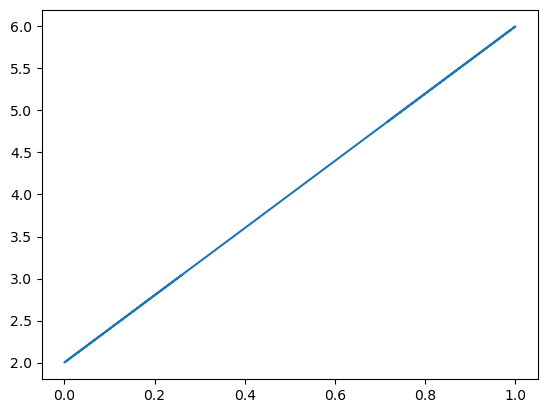

In [5]:
x = distribution.sample((10000,))  # x ~ p(X)
y = transform(x) 
ladj = transform.log_abs_det_jacobian(x, y)  # log |det df(x)/dx|

plt.plot(x, y)

In [6]:
ladj

tensor([1.3863, 1.3863, 1.3863,  ..., 1.3863, 1.3863, 1.3863])

(0.0, 3000.0)

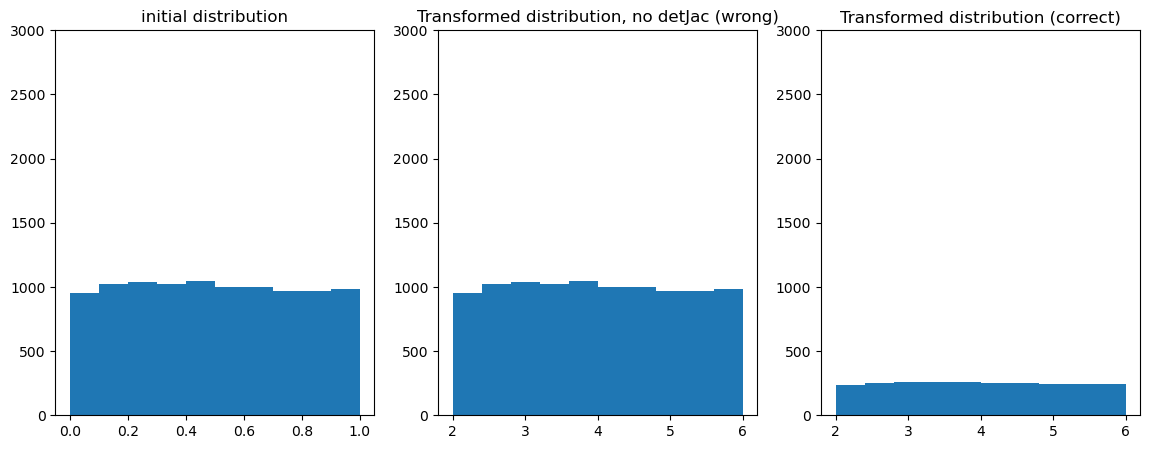

In [19]:
f , axs = plt.subplots(1, 3, figsize=(14, 5))
axs[0].hist(x, bins=10, range=(0,1));
axs[0].set_title("initial distribution")
axs[1].hist(y, bins=10, range=(2,6));
axs[1].set_title("Transformed distribution, no detJac (wrong)")
axs[2].hist(y, weights=1/ladj.exp(), bins=10, range=(2,6));
axs[2].set_title("Transformed distribution (correct)")
axs[0].set_ylim(0, 3000)
axs[1].set_ylim(0, 3000)
axs[2].set_ylim(0, 3000)

AffineTransform --> constant determinat

In [20]:
ladj

tensor([1.3863, 1.3863, 1.3863,  ..., 1.3863, 1.3863, 1.3863])

## Non-affine transformation

In [53]:
transform = torch.distributions.ExpTransform()
distribution = torch.distributions.Uniform(low=torch.tensor(0.), high=torch.tensor(1.))

x = distribution.sample((10000,))  # x ~ p(X)
y = transform(x) 
ladj = transform.log_abs_det_jacobian(x, y)  # log |det df(x)/dx|


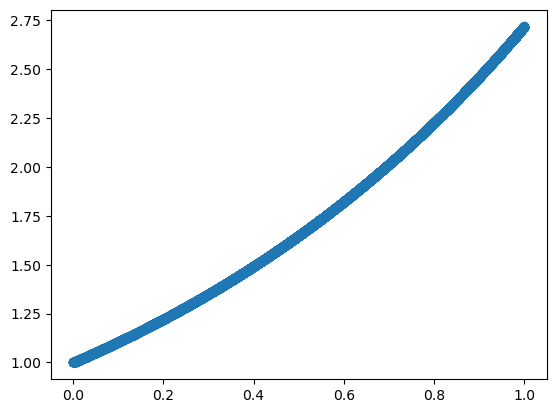

In [54]:
plt.scatter(x, y)

In [41]:
y

tensor([1.1209, 1.5457, 2.5476,  ..., 2.3632, 1.2297, 2.7044])

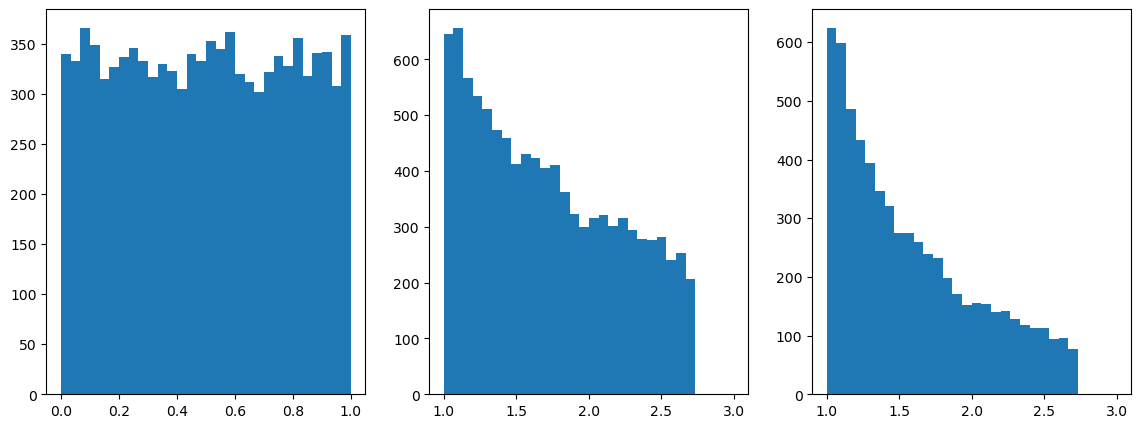

In [77]:
f , axs = plt.subplots(1, 3, figsize=(14, 5))
counts_1, xbins_1, _ = axs[0].hist(x, bins=30, range=(0, 1));
counts_2, xbins_2, _ = axs[1].hist(y,  bins=30, range=(1, 3));
counts_3, xbins_3, _ = axs[2].hist(y, weights=1/ladj.exp(), bins=30, range=(1, 3));

The determinant of the jacoban is no more constant

In [81]:
ladj

tensor([0.4817, 0.0224, 0.6249,  ..., 0.3159, 0.2377, 0.0146])

# Normalizing Flows

A Normalizing Flows (NF) is a set of invertible transformations that brings a complex p.d.f to a simple base distribution (usually a gaussian). 
- We can sample points from p.d.f represented by the NF, sampling from the base distribution and tranforming them. 
- We can compute the log_prob of samples by bringing the point to the base distribution and using the base pdf and the detJacobian of the transformations. 

In [2]:
transform = torch.distributions.ExpTransform().inv
distribution = torch.distributions.Uniform(low=torch.tensor(0.), high=torch.tensor(1.))

# uniform --> exp transform --> fnal distrbution

flow = zuko.distributions.NormalizingFlow(transform, distribution)

x = flow.sample()
log_p = flow.log_prob(x)

x, log_p

(tensor(1.1708), tensor(-0.1577))

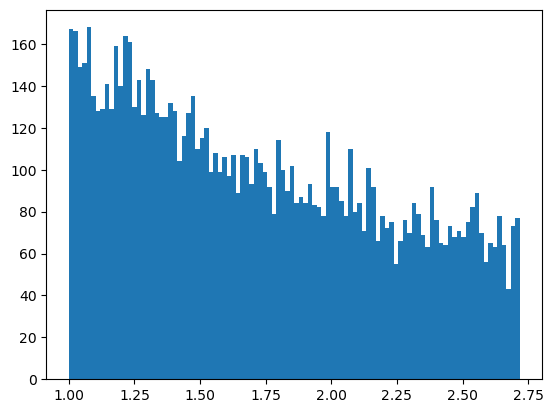

In [3]:
x = flow.sample((10000,))
plt.hist(x,  bins=100);

The set of transformations makes possible to create complex pdf.

The transformations list is always considered in the **normalizing direction**: from the output pdf to the base distribution

In [52]:
flow = Flow(
    transform=[
        MaskedAutoregressiveTransform(features=4, hidden_features=(64, 64)),
        UnconditionalTransform(RotationTransform, torch.randn(4,4)),
        MaskedAutoregressiveTransform(features=4, hidden_features=(64, 64)),
    ],
    base=UnconditionalDistribution(
        DiagNormal,
        torch.zeros(4),
        torch.ones(4),
        buffer=True,
    ),
)

In [53]:
flow

Flow(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1, 2, 3]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=8, bias=True)
      )
    )
    (1): UnconditionalTransform(RotationTransform())
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1, 2, 3]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=8, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([4]), scale: torch.Size([4])))
)

In [54]:
y =  flow().sample((10000,))

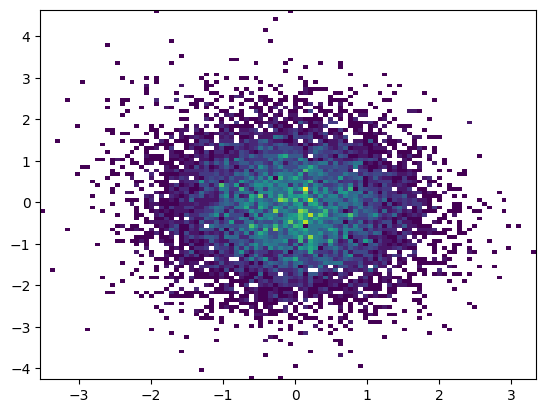

In [55]:
plt.hist2d(y[:,0], y[:,1], bins =100, cmin=1);

In [56]:
flow

Flow(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1, 2, 3]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=8, bias=True)
      )
    )
    (1): UnconditionalTransform(RotationTransform())
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1, 2, 3]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=4, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=8, bias=True)
      )
    )
  )
  (base): UnconditionalDistribution(DiagNormal(loc: torch.Size([4]), scale: torch.Size([4])))
)

## Two-moons example

Let's generate a simple 2 dimensional dataset.   The downward looking half-moon has label 0, the upward looking one label 1.

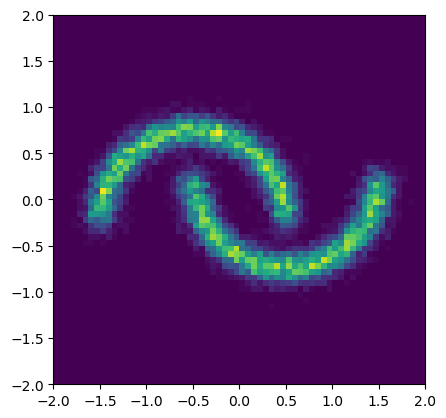

In [7]:
def two_moons(n: int, sigma: float = 1e-1):
    theta = 2 * torch.pi * torch.rand(n)
    label = (theta > torch.pi).float()

    x = torch.stack(
        (
            torch.cos(theta) + label - 1 / 2,
            torch.sin(theta) + label / 2 - 1 / 4,
        ),
        axis=-1,
    )

    return torch.normal(x, sigma), label


samples, labels = two_moons(16384)

plt.figure(figsize=(4.8, 4.8))
plt.hist2d( samples[:,0].numpy(), samples[:, 1].numpy(), bins=(64,64), range=((-2, 2), (-2, 2)))
plt.show()


In [21]:
trainset = data.TensorDataset(*two_moons(16384))
trainloader = data.DataLoader(trainset, batch_size=64, shuffle=True)


We use a neural spline flow (NSF) as density estimator . The goal of the unconditional flow is to approximate the entire Two Moons distribution.

In [55]:
flow = zuko.flows.NSF(features=2, transforms=3, hidden_features=(64, 64))
flow

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=46, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_featur

In [56]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
flow = flow.to("cuda")


for epoch in range(20):
    losses = []

    for x, label in trainloader:
        loss = -flow().log_prob(x.to("cuda")).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())


(0) 1.3502659797668457 ± 0.282270610332489
(1) 1.141944169998169 ± 0.1002446636557579
(2) 1.1113195419311523 ± 0.09832210838794708
(3) 1.090111255645752 ± 0.09192914515733719
(4) 1.0887610912322998 ± 0.09937533736228943
(5) 1.0796864032745361 ± 0.08719023317098618
(6) 1.07930588722229 ± 0.09476713091135025
(7) 1.0784568786621094 ± 0.09546641260385513
(8) 1.0780729055404663 ± 0.0936511904001236
(9) 1.068918228149414 ± 0.09719716012477875
(10) 1.0676681995391846 ± 0.09808702021837234
(11) 1.069662094116211 ± 0.09566018730401993
(12) 1.0634970664978027 ± 0.08941050618886948
(13) 1.0646753311157227 ± 0.08743206411600113
(14) 1.056154727935791 ± 0.0844043642282486
(15) 1.0651378631591797 ± 0.09600220620632172
(16) 1.0619750022888184 ± 0.09257636219263077
(17) 1.0647386312484741 ± 0.09104281663894653
(18) 1.058343768119812 ± 0.09851361811161041
(19) 1.052592158317566 ± 0.09266822785139084


We have now a normalizin flow model that should have learnt the function to transform the 2 moons distribution in a 2D guassian distribution. 

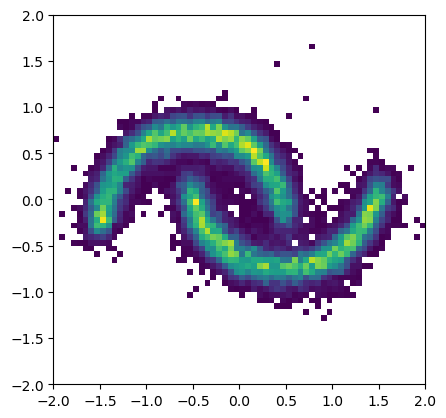

In [57]:
samples = flow().sample((30000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d( samples[:,0].cpu().numpy(), samples[:, 1].cpu().numpy(), bins=(64,64), range=((-2, 2), (-2, 2)), cmin=1)
plt.show()

We can use the transformation function learned by the flow to *transport* the initial points to the latent space, and **check** that is gaussian.

In [58]:
z = flow().transform(samples)

Text(0.5, 0, '$z_2$')

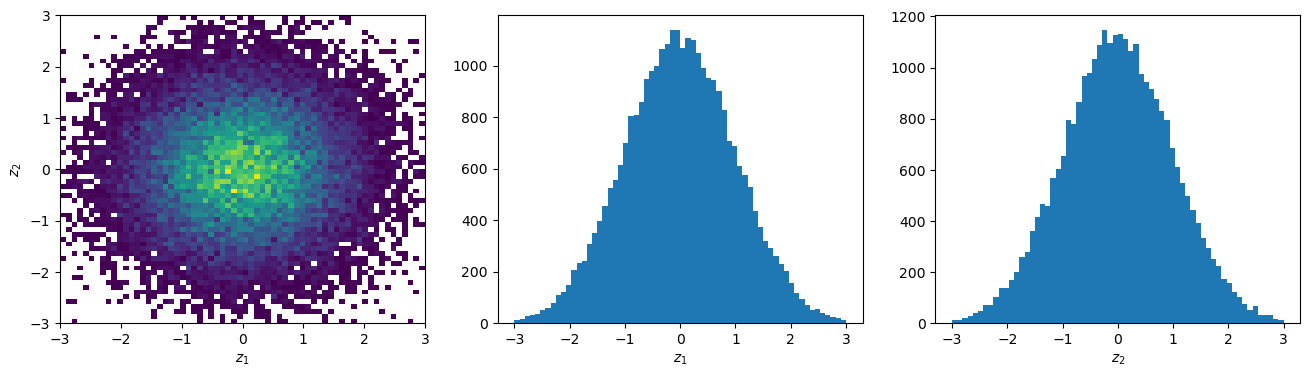

In [59]:
plt.figure(figsize=(16,4))
plt.subplot(1,3,1)
plt.hist2d( z[:,0].detach().cpu().numpy(), z[:, 1].detach().cpu().numpy(), bins=(64,64), range=((-3, 3), (-3, 3)), cmin=1)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$")
plt.subplot(1,3,2)
plt.hist( z[:,0].detach().cpu().numpy(), bins=64, range=(-3, 3))
plt.xlabel("$z_1$")
plt.subplot(1,3,3)
plt.hist( z[:,1].detach().cpu().numpy(), bins=64, range=(-3, 3));
plt.xlabel("$z_2$")

We can also look at the trasformation layer by layer

In [62]:
z1 = flow.transform().transforms[0](samples)
z2 = flow.transform().transforms[1](z1)
z3 = flow.transform().transforms[2](z2)

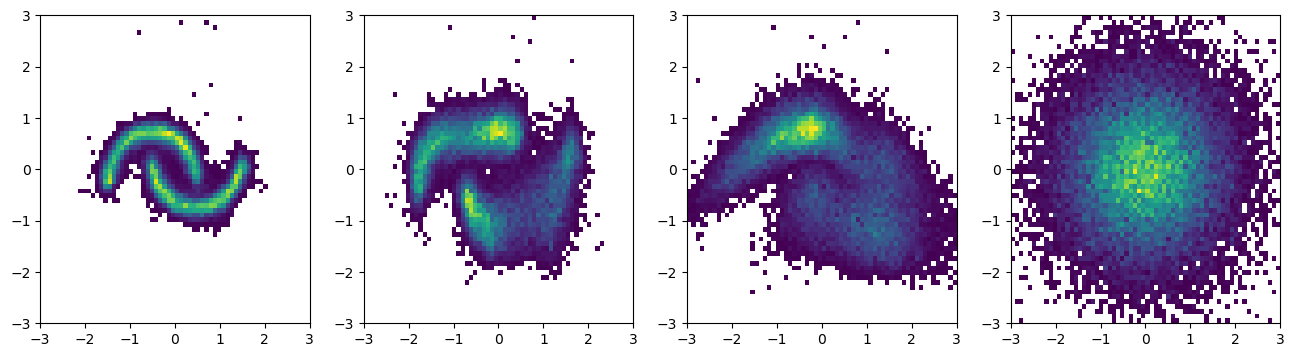

In [63]:
plt.figure(figsize=(16,4))
plt.subplot(1,4,1)
plt.hist2d( samples[:,0].detach().cpu().numpy(), samples[:, 1].detach().cpu().numpy(), bins=(64,64),
           range=((-3, 3), (-3, 3)), cmin=1)
plt.subplot(1,4,2)
plt.hist2d( z1[:,0].detach().cpu().numpy(), z1[:, 1].detach().cpu().numpy(), bins=(64,64), 
           range=((-3, 3), (-3, 3)), cmin=1)
plt.subplot(1,4,3)
plt.hist2d( z2[:,0].detach().cpu().numpy(), z2[:, 1].detach().cpu().numpy(), bins=(64,64), 
           range=((-3, 3), (-3, 3)), cmin=1)
plt.subplot(1,4,4)
plt.hist2d( z3[:,0].detach().cpu().numpy(), z3[:, 1].detach().cpu().numpy(), bins=(64,64),
            range=((-3, 3), (-3, 3)), cmin=1);


# Conditional  Normalizing Flows
The transformations can be conditional on external tensors. We can model $p(x|c)$. 

In [105]:
flow_conditional = Flow(
    transform=[
        MaskedAutoregressiveTransform(features=2, context=3, hidden_features=(64, 64)),
        UnconditionalTransform(RotationTransform, torch.randn(2, 2)),
        MaskedAutoregressiveTransform(features=2, context=3, hidden_features=(64, 64)),
    ],
    base=UnconditionalDistribution(
        DiagNormal,
        torch.zeros(2),
        torch.ones(2),
        buffer=True,
    ),
)

We can sample 1 event for each conditioning entry.

In [106]:
c = torch.rand((10000, 3))
print(c)

tensor([[0.6101, 0.7621, 0.4143],
        [0.3979, 0.0959, 0.4791],
        [0.8686, 0.4019, 0.5394],
        ...,
        [0.9682, 0.5763, 0.8514],
        [0.2727, 0.4647, 0.0228],
        [0.0824, 0.7400, 0.9557]])


We have now 10k different distributions evalutate by zuko

In [107]:
flow_conditional(c)

NormalizingFlow(
  (transform): ComposedTransform(
    (0): AutoregressiveTransform()
    (1): RotationTransform()
    (2): AutoregressiveTransform()
  )
  (base): DiagNormal(loc: torch.Size([10000, 2]), scale: torch.Size([10000, 2]))
)

Let's get 1 sample for each flow

In [108]:
y =  flow_conditional(c).sample((1,))
y.shape

torch.Size([1, 10000, 2])

We can sample multiple event for each conditioning entry. (Be careful with memory!)

In [109]:
c = torch.rand((10000, 3))
y =  flow_conditional(c).sample((10,))
y.shape

torch.Size([10, 10000, 2])

In [110]:
y[:,:,0].shape

torch.Size([10, 10000])

## Two moons conditional - example

In [40]:
flow = zuko.flows.NSF(features=2, context=1, transforms=3, hidden_features=(64, 64))

In [41]:
optimizer = torch.optim.Adam(flow.parameters(), lr=1e-3)
flow = flow.to("cuda")

for epoch in range(8):
    losses = []

    for x, label in trainloader:
        # Now using the label to distinguish the two moons
        c = label.unsqueeze(dim=-1).to("cuda")
    
        loss = -flow(c).log_prob(x.to("cuda")).mean()
        loss.backward()

        optimizer.step()
        optimizer.zero_grad()

        losses.append(loss.detach())

    losses = torch.stack(losses)

    print(f"({epoch})", losses.mean().item(), "±", losses.std().item())

(0) 0.6919867396354675 ± 0.40713125467300415
(1) 0.42619043588638306 ± 0.09947315603494644
(2) 0.4051658511161804 ± 0.10099725425243378
(3) 0.3911624550819397 ± 0.10852503776550293
(4) 0.38362953066825867 ± 0.10384397208690643
(5) 0.37918606400489807 ± 0.09568245708942413
(6) 0.3832094669342041 ± 0.09854519367218018
(7) 0.3823072910308838 ± 0.08806762099266052


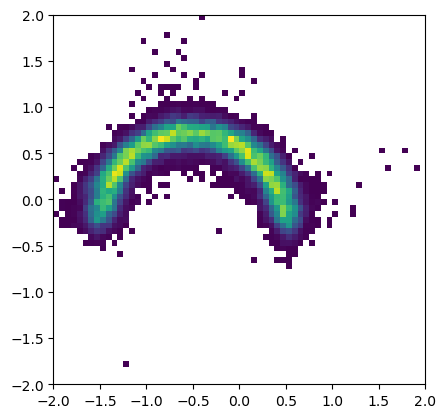

In [44]:
samples = flow(torch.tensor([0.0], device="cuda")).sample((30000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d( samples[:,0].cpu().numpy(), samples[:, 1].cpu().numpy(), bins=(64,64), range=((-2, 2), (-2, 2)), cmin=1)
plt.show()

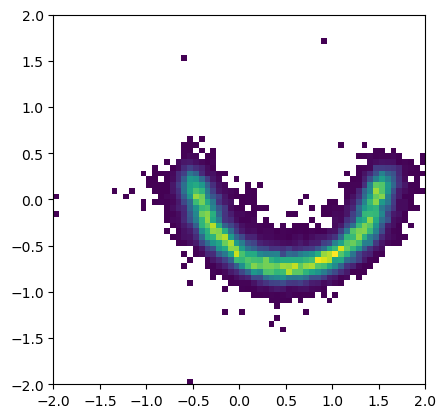

In [45]:
samples = flow(torch.tensor([1.0], device="cuda")).sample((30000,))

plt.figure(figsize=(4.8, 4.8))
plt.hist2d( samples[:,0].cpu().numpy(), samples[:, 1].cpu().numpy(), bins=(64,64), range=((-2, 2), (-2, 2)), cmin=1)
plt.show()

# Normalizing Flow types

## Coupling affine layers

NICE: Non-linear Independent Components Estimation (Dinh et al., 2014)
https://arxiv.org/abs/1410.8516

https://zuko.readthedocs.io/stable/api/zuko.flows.coupling.html


In [70]:
flow = zuko.flows.coupling.NICE(features=5, context=0, transforms=4, randmask=True)
flow

NICE(
  (transform): LazyComposedTransform(
    (0): GeneralCouplingTransform(
      (base): MonotonicAffineTransform()
      (mask): [1, 0, 1, 0, 1]
      (hyper): MLP(
        (0): Linear(in_features=3, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=4, bias=True)
      )
    )
    (1): GeneralCouplingTransform(
      (base): MonotonicAffineTransform()
      (mask): [0, 0, 1, 1, 0]
      (hyper): MLP(
        (0): Linear(in_features=2, out_features=64, bias=True)
        (1): ReLU()
        (2): Linear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): Linear(in_features=64, out_features=6, bias=True)
      )
    )
    (2): GeneralCouplingTransform(
      (base): MonotonicAffineTransform()
      (mask): [1, 1, 0, 0, 1]
      (hyper): MLP(
        (0): Linear(in_features=3, out_features=64, bias=True)
        (1): ReLU()
       

## Masked Autoregressive Flows (MAF)
https://arxiv.org/abs/1705.07057

https://zuko.readthedocs.io/stable/api/zuko.flows.autoregressive.html

We choose to implement the set of functions in the coupling layers with masking, following the approach used
by MADE. MADE is a feedforward network that takes x as input and outputs μi and αi for
all i with a single forward pass. The autoregressive property is enforced by multiplying the weight
matrices of MADE with suitably constructed binary masks. In other words, we use MADE with
Gaussian conditionals as the building layer of our flow. 

In [75]:
flow = zuko.flows.autoregressive.MAF(features=10, context=0, transforms=4, randperm=False)
flow

MAF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=10, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=20, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=10, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=20, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicAffineTransform()
      (order): [0, 1, 2, 3, 4, 5, 6, 7, 8,

In [78]:
x = torch.rand(10000, 10)

In [79]:
%%timeit
flow().log_prob(x)

929 ms ± 33.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [80]:
%%timeit
flow().sample((10000,))

7.54 s ± 668 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


A masked MLP is a very efficiency model that uses a DNN and a simple mask to create a function where each element of the output depends only on some element of the input. It is very efficiency to compute, hence is the core of many normalizing flow layers.

In [81]:
adjacency = torch.randn(4, 3) < 0
print(adjacency)
net = zuko.nn.MaskedMLP(adjacency, [16, 32], activation=torch.nn.ELU)

net

tensor([[ True, False,  True],
        [ True,  True,  True],
        [False,  True,  True],
        [False, False, False]])


MaskedMLP(
  (0): MaskedLinear(in_features=3, out_features=16, bias=True)
  (1): ELU(alpha=1.0)
  (2): MaskedLinear(in_features=16, out_features=32, bias=True)
  (3): ELU(alpha=1.0)
  (4): MaskedLinear(in_features=32, out_features=4, bias=True)
)

In [83]:
x = torch.randn(3)

torch.autograd.functional.jacobian(net, x)

tensor([[ 0.0429,  0.0000, -0.0005],
        [-0.0742,  0.0625,  0.0680],
        [ 0.0000,  0.0665,  0.0020],
        [ 0.0000,  0.0000,  0.0000]])

## Spline flows

The most powerful ones: https://zuko.readthedocs.io/stable/api/zuko.flows.spline.html

Neural Spline Flows (Durkan et al., 2019)
https://arxiv.org/abs/1906.04032


### With coupling structure

In [86]:
# passes=2 means coupling layer
flow = zuko.flows.spline.NSF(features=10, context=0, bins=8, passes=2, hidden_features=[64,64])
flow

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=10, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=230, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=10, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=230, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 0, 0, 0, 0, 

In [87]:
x = torch.rand(10000, 10)

In [88]:
%%timeit
flow().log_prob(x)

1.51 s ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [89]:
%%timeit
flow().sample((10000,))

2.51 s ± 59.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


Note the coupling struction in the Transformation. 

In [90]:
# passes=None means fully autoregressive 
flow = zuko.flows.spline.NSF(features=10, context=0, bins=8, passes=None, hidden_features=[64,64])
flow

NSF(
  (transform): LazyComposedTransform(
    (0): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=10, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=230, bias=True)
      )
    )
    (1): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [9, 8, 7, 6, 5, 4, 3, 2, 1, 0]
      (hyper): MaskedMLP(
        (0): MaskedLinear(in_features=10, out_features=64, bias=True)
        (1): ReLU()
        (2): MaskedLinear(in_features=64, out_features=64, bias=True)
        (3): ReLU()
        (4): MaskedLinear(in_features=64, out_features=230, bias=True)
      )
    )
    (2): MaskedAutoregressiveTransform(
      (base): MonotonicRQSTransform(bins=8)
      (order): [0, 1, 2, 3, 4, 

In [91]:
x = torch.rand(1000, 10)

In [92]:
%%timeit
flow().log_prob(x)

545 ms ± 14.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [93]:
%%timeit
flow().sample((1000,))

6.02 s ± 986 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Circular spline flow

It is possible to define flow over the circle --> periodic spline flows 

In [13]:
flow = zuko.flows.spline.NCSF(features=2, context=0, bins=8)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-4.  , -3.92, -3.84, -3.76, -3.68, -3.6 , -3.52, -3.44, -3.36,
        -3.28, -3.2 , -3.12, -3.04, -2.96, -2.88, -2.8 , -2.72, -2.64,
        -2.56, -2.48, -2.4 , -2.32, -2.24, -2.16, -2.08, -2.  , -1.92,
        -1.84, -1.76, -1.68, -1.6 , -1.52, -1.44, -1.36, -1.28, -1.2 ,
        -1.12, -1.04, -0.96, -0.88, -0.8 , -0.72, -0.64, -0.56, -0.48,
        -0.4 , -0.32, -0.24, -0.16, -0.08,  0.  ,  0.08,  0.16,  0.24,
         0.32,  0.4 ,  0.48,  0.56,  0.64,  0.72,  0.8 ,  0.88,  0.96,
         1.04,  1.12,  1.2 ,  1.28,  1.36,  1.44,  1.52,  1.6 ,  1.68,
         1.76,  1.84,  1.92,  2.  ,  2.08,  2.16,  2.24,  2.32,  2.4 ,
         2.48,  2.56,  2.64,  2.72,  2.8 ,  2.88,  2.96,  3.04,  3.12,
         3.2 ,  3.28,  3.36,  3.44,  3.52

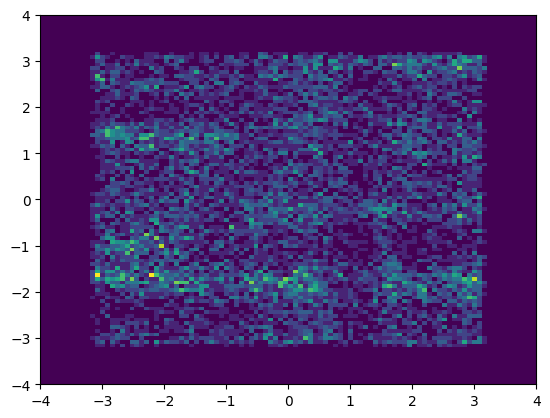

In [17]:
samples = flow().sample((10000,))
plt.hist2d(samples[:,0], samples[:,1], bins=100, range=((-4,4),(-4,4)))